In [1]:
import pandas as pd
import scanpy as sc

In [2]:
adata = sc.read_h5ad("./output/adata_v2.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 2730 × 1000
    obs: 'paul15_clusters', 'n_counts_all', 'louvain', 'louvain_anno', 'cell_type', 'dpt_pseudotime'
    var: 'n_counts', 'mean', 'std'
    uns: 'cell_type_colors', 'dendrogram_cell_type', 'diffmap_evals', 'draw_graph', 'iroot', 'log1p', 'louvain', 'louvain_anno_colors', 'louvain_anno_sizes', 'louvain_colors', 'louvain_sizes', 'neighbors', 'paga', 'paul15_clusters_colors', 'pca', 'tsne'
    obsm: 'X_diffmap', 'X_draw_graph_fa', 'X_pca', 'X_tsne'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

### Read the transition indicies
---

In [4]:
def read_tab_separated_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        
    data = []
    for line in lines:
        # Strip any surrounding whitespace and split by tabs
        numbers = line.strip().split(', ')
        # Convert the strings to integers or floats
        numbers = [str(int(num)) for num in numbers]
        data.append(numbers)
    
    return data

transition_indicies_filepath = './data/transition_indices.txt'
data_cell_indicies = read_tab_separated_file(transition_indicies_filepath)


In [5]:
data_cell_indicies[0]

['56',
 '233',
 '266',
 '998',
 '1156',
 '1379',
 '1497',
 '1659',
 '2063',
 '2266',
 '2315',
 '2464',
 '2637']

### Read the cell pairs file

In [6]:
def read_tab_separated_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        
    data = []
    for line in lines:
        # Strip any surrounding whitespace and split by tabs
        cells = line.strip().split(', ')
        # Convert the strings to integers or floats
        cells = [str(cell) for cell in cells]
        data.append(cells)
    
    return data

cell_pairs_filepath = './data/cell_pairs.txt'
data_cell_pairs = read_tab_separated_file(cell_pairs_filepath)

In [7]:
data_cell_pairs

[['Ery0', 'Ery1'],
 ['Ery1', 'Ery3'],
 ['HPC', 'Monocyte Progenitor'],
 ['Ery3', 'Ery4'],
 ['HPC', 'Monocyte Progenitor', 'Neutrophils'],
 ['Ery0', 'Ery2', 'Ery3', 'Ery4'],
 ['Ery0', 'Ery4'],
 ['Monocyte Progenitor', 'Neutrophils'],
 ['Early Progenitor', 'HPC'],
 ['HPC', 'Neutrophils'],
 ['Early Progenitor', 'Ery4'],
 ['Ery4', 'Mep'],
 ['Ery0', 'Ery2', 'Ery4'],
 ['Ery0', 'Ery3', 'Ery4'],
 ['Basophil', 'HPC'],
 ['Basophil', 'Neutrophils'],
 ['Ery4', 'HPC', 'Neutrophils'],
 ['Ery2', 'Ery4'],
 ['Ery0', 'Mep'],
 ['Ery0', 'HPC', 'Neutrophils'],
 ['Basophil', 'HPC', 'Neutrophils'],
 ['HPC', 'Lymph'],
 ['Ery0', 'HPC', 'Monocyte Progenitor', 'Neutrophils'],
 ['Ery0', 'Ery3'],
 ['Ery0', 'HPC'],
 ['Ery0', 'Monocyte Progenitor', 'Neutrophils'],
 ['DC', 'HPC']]

### Make a copy of cell_type column in obs dataframe and name it as cell_type_w_hybrids

In [8]:
adata.obs

,paul15_clusters,n_counts_all,louvain,louvain_anno,cell_type,dpt_pseudotime
0,7MEP,353.0,8,8,Ery4,0.225547
1,15Mo,2556.0,1,1,Monocyte Progenitor,0.273524
2,3Ery,4649.0,17,17,Ery0,0.710179
3,15Mo,4486.0,2,2,Neutrophils,0.267904
4,3Ery,5205.0,17,17,Ery0,0.781939
...,...,...,...,...,...,...
2725,2Ery,4873.0,6,6,Ery1,0.649140
2726,13Baso,3553.0,24,24/Mo,Monocyte Progenitor,0.298521
2727,7MEP,443.0,8,8,Ery4,0.196117
2728,15Mo,3252.0,2,2,Neutrophils,0.264164


In [9]:
adata.obs["cell_type_w_hybrids"] = adata.obs['cell_type']

In [10]:
assert len(data_cell_indicies) == len(data_cell_pairs)

In [11]:
for idx in range(len(data_cell_indicies)):
    indices = data_cell_indicies[idx]
    cell_types = data_cell_pairs[idx]
    cell_type_name_hyb = "-".join(cell_types) + "-Hybrid"
    adata.obs['cell_type_w_hybrids'].cat.add_categories(cell_type_name_hyb, inplace=True)
    # Rename the cell_type for the given indices to 'xyz'
    adata.obs.loc[indices, 'cell_type_w_hybrids'] = cell_type_name_hyb

/usr/local/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


In [12]:
import numpy as np
import matplotlib.pyplot as pl
from matplotlib import rc_context

In [13]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
# low dpi (dots per inch) yields small inline figures
sc.settings.set_figure_params(dpi=200, frameon=False, figsize=(3, 3), facecolor="white", color_map="viridis_r")

-----
anndata     0.8.0
scanpy      1.9.3
-----
PIL                 9.5.0
anyio               NA
arrow               1.2.3
attr                23.2.0
babel               2.14.0
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
cached_property     1.5.2
certifi             2024.07.04
cffi                1.15.1
charset_normalizer  3.3.2
cycler              0.10.0
cython_runtime      NA
dateutil            2.9.0.post0
debugpy             1.7.0
decorator           5.1.1
defusedxml          0.7.1
entrypoints         0.4
fastjsonschema      NA
fqdn                NA
h5py                3.8.0
idna                3.7
igraph              0.10.8
importlib_resources NA
ipykernel           6.16.2
ipython_genutils    0.2.0
isoduration         NA
jedi                0.19.1
jinja2              3.1.4
joblib              1.3.2
json5               NA
jsonpointer         3.0.0
jsonschema          4.17.3
jupyter_server      1.24.0
jupyterlab_server   2.24.0
kiwisolver          1.4.5


In [14]:
adata.obs["louvain"].cat.categories

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24'],
      dtype='object')

In [15]:
adata.obs["cell_type"].cat.categories

Index(['Basophil', 'DC', 'Early Progenitor', 'Ery0', 'Ery1', 'Ery2', 'Ery3',
       'Ery4', 'HPC', 'Lymph', 'Mep', 'Monocyte Progenitor', 'Neutrophils'],
      dtype='object')

In [16]:
adata.obs["cell_type_new_names"] = adata.obs["louvain"].map(
    {
        '0': "0-HPC",
        '1': "1-Mono",  # Monocyte Progenitor
        '2': "2-Neut",  # Neutrophils
        '3': "3-Ery0",
        '4': "4-HPC",
        '5': "5-Ery0",
        '6': "6-Ery1",
        '7': "7-Ery4",
        '8': "8-Ery4",
        '9': "9-Mono",  # Monocyte Progenitor
        '10': "10-Ery0",
        '11': "11-Mono",  # Monocyte Progenitor
        '12': "12-Ery4",
        '13': "13-Ery3",
        '14': "14-Neut",  # Neutrophils
        '15': "15-Ery1",
        '16': "16-EPro",  # Early Progenitor
        '17': "17-Ery0",
        '18': "18-Ery2",
        '19': "19-Neut",  # Neutrophils
        '20': "20-Mep",
        '21': "21-DC",
        '22': "22-Baso",  # Basophil
        '23': "23-Lymp",  # Lymph
        '24': "24-Mono"   # Monocyte Progenitor
    }
)


In [17]:
shortened_names = ['Baso', 'DC', 'EPro', 'E0', 'E1', 'E2', 'E3', 'E4', 'HPC', 'Lymp', 
 'Mep', 'Mono', 'Neut', 'E0-E1-Hyb', 'E1-E3-Hyb', 'HPC-Mono-Hyb', 
 'E3-E4-Hyb', 'HPC-Mono-Neut-Hyb', 'E0-E2-E3-E4-Hyb', 'E0-E4-Hyb', 
 'Mono-Neut-Hyb', 'EPro-HPC-Hyb', 'HPC-Neut-Hyb', 'EPro-E4-Hyb', 
 'E4-Mep-Hyb', 'E0-E2-E4-Hyb', 'E0-E3-E4-Hyb', 'Baso-HPC-Hyb', 
 'Baso-Neut-Hyb', 'E4-HPC-Neut-Hyb', 'E2-E4-Hyb', 'E0-Mep-Hyb', 
 'E0-HPC-Neut-Hyb', 'Baso-HPC-Neut-Hyb', 'HPC-Lymp-Hyb', 
 'E0-HPC-Mono-Neut-Hyb', 'E0-E3-Hyb', 'E0-HPC-Hyb', 
 'E0-Mono-Neut-Hyb', 'DC-HPC-Hyb']

In [18]:
adata.obs['cell_type_hyb'] = adata.obs["cell_type_w_hybrids"]

In [19]:
adata.obs['cell_type_hyb'].cat.categories = shortened_names

In [21]:
sc.tl.paga(adata, groups="cell_type_new_names")

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


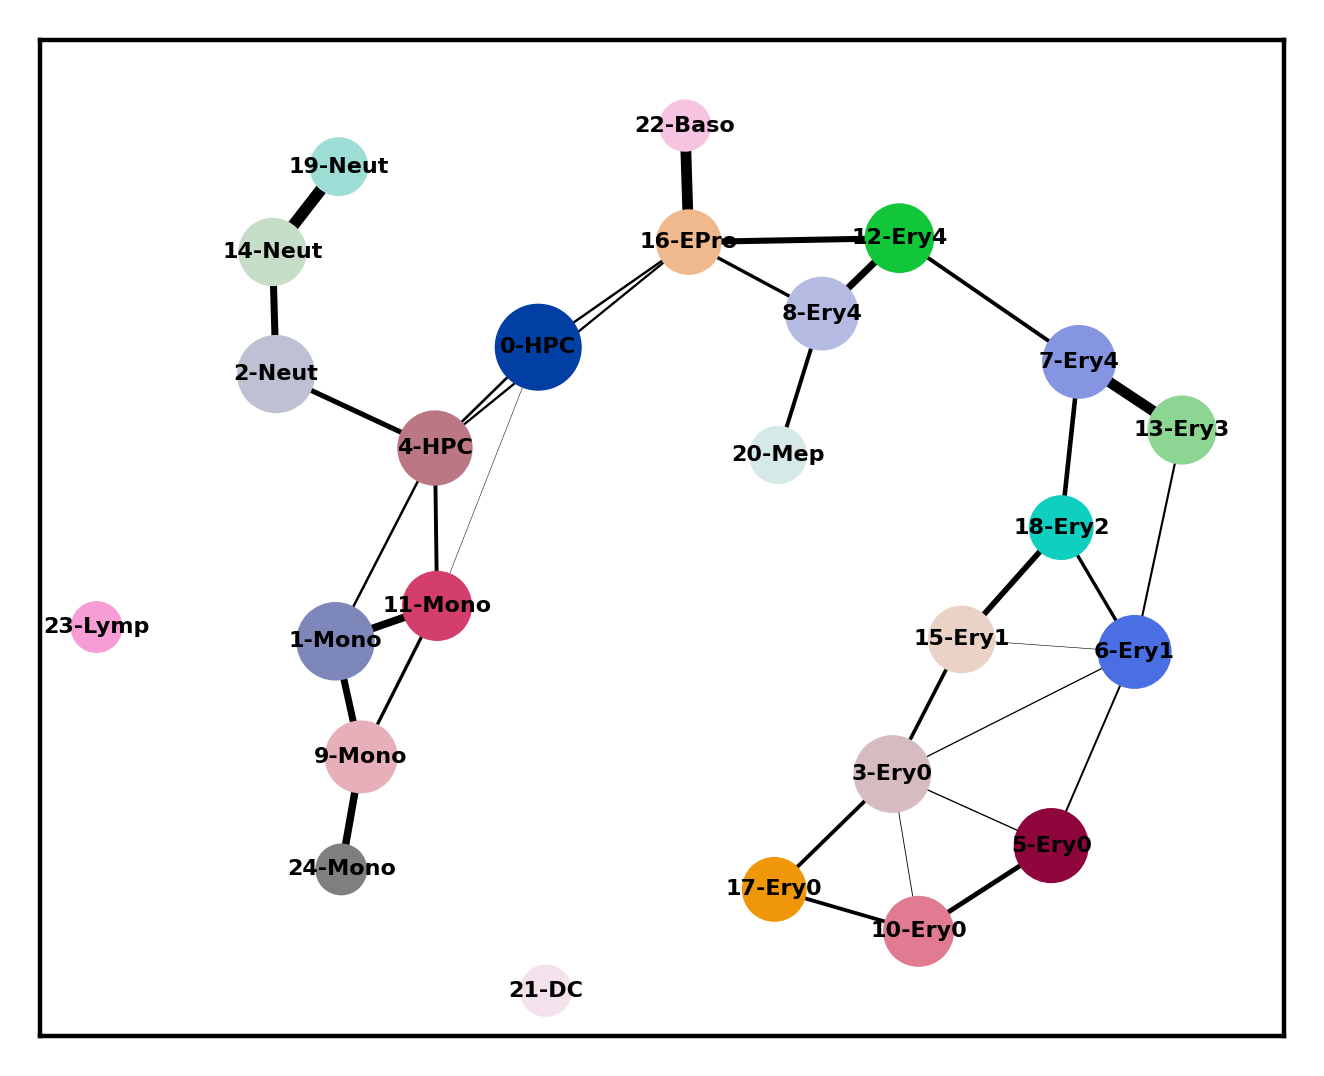

In [22]:
# Set the figure size and font sizes for tick labels, axis labels, and titles
with rc_context({
    "figure.figsize": (4, 3),
    "axes.labelsize": 6,  # Font size for axis labels
    "axes.titlesize": 8   # Font size for titles
}):
    sc.pl.paga(adata,
               threshold=0.03,
               show=False,
               edge_width_scale=0.3,
               fontsize=4,
               frameon=True
              )

In [23]:
sc.tl.draw_graph(adata, init_pos="paga")

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:15)


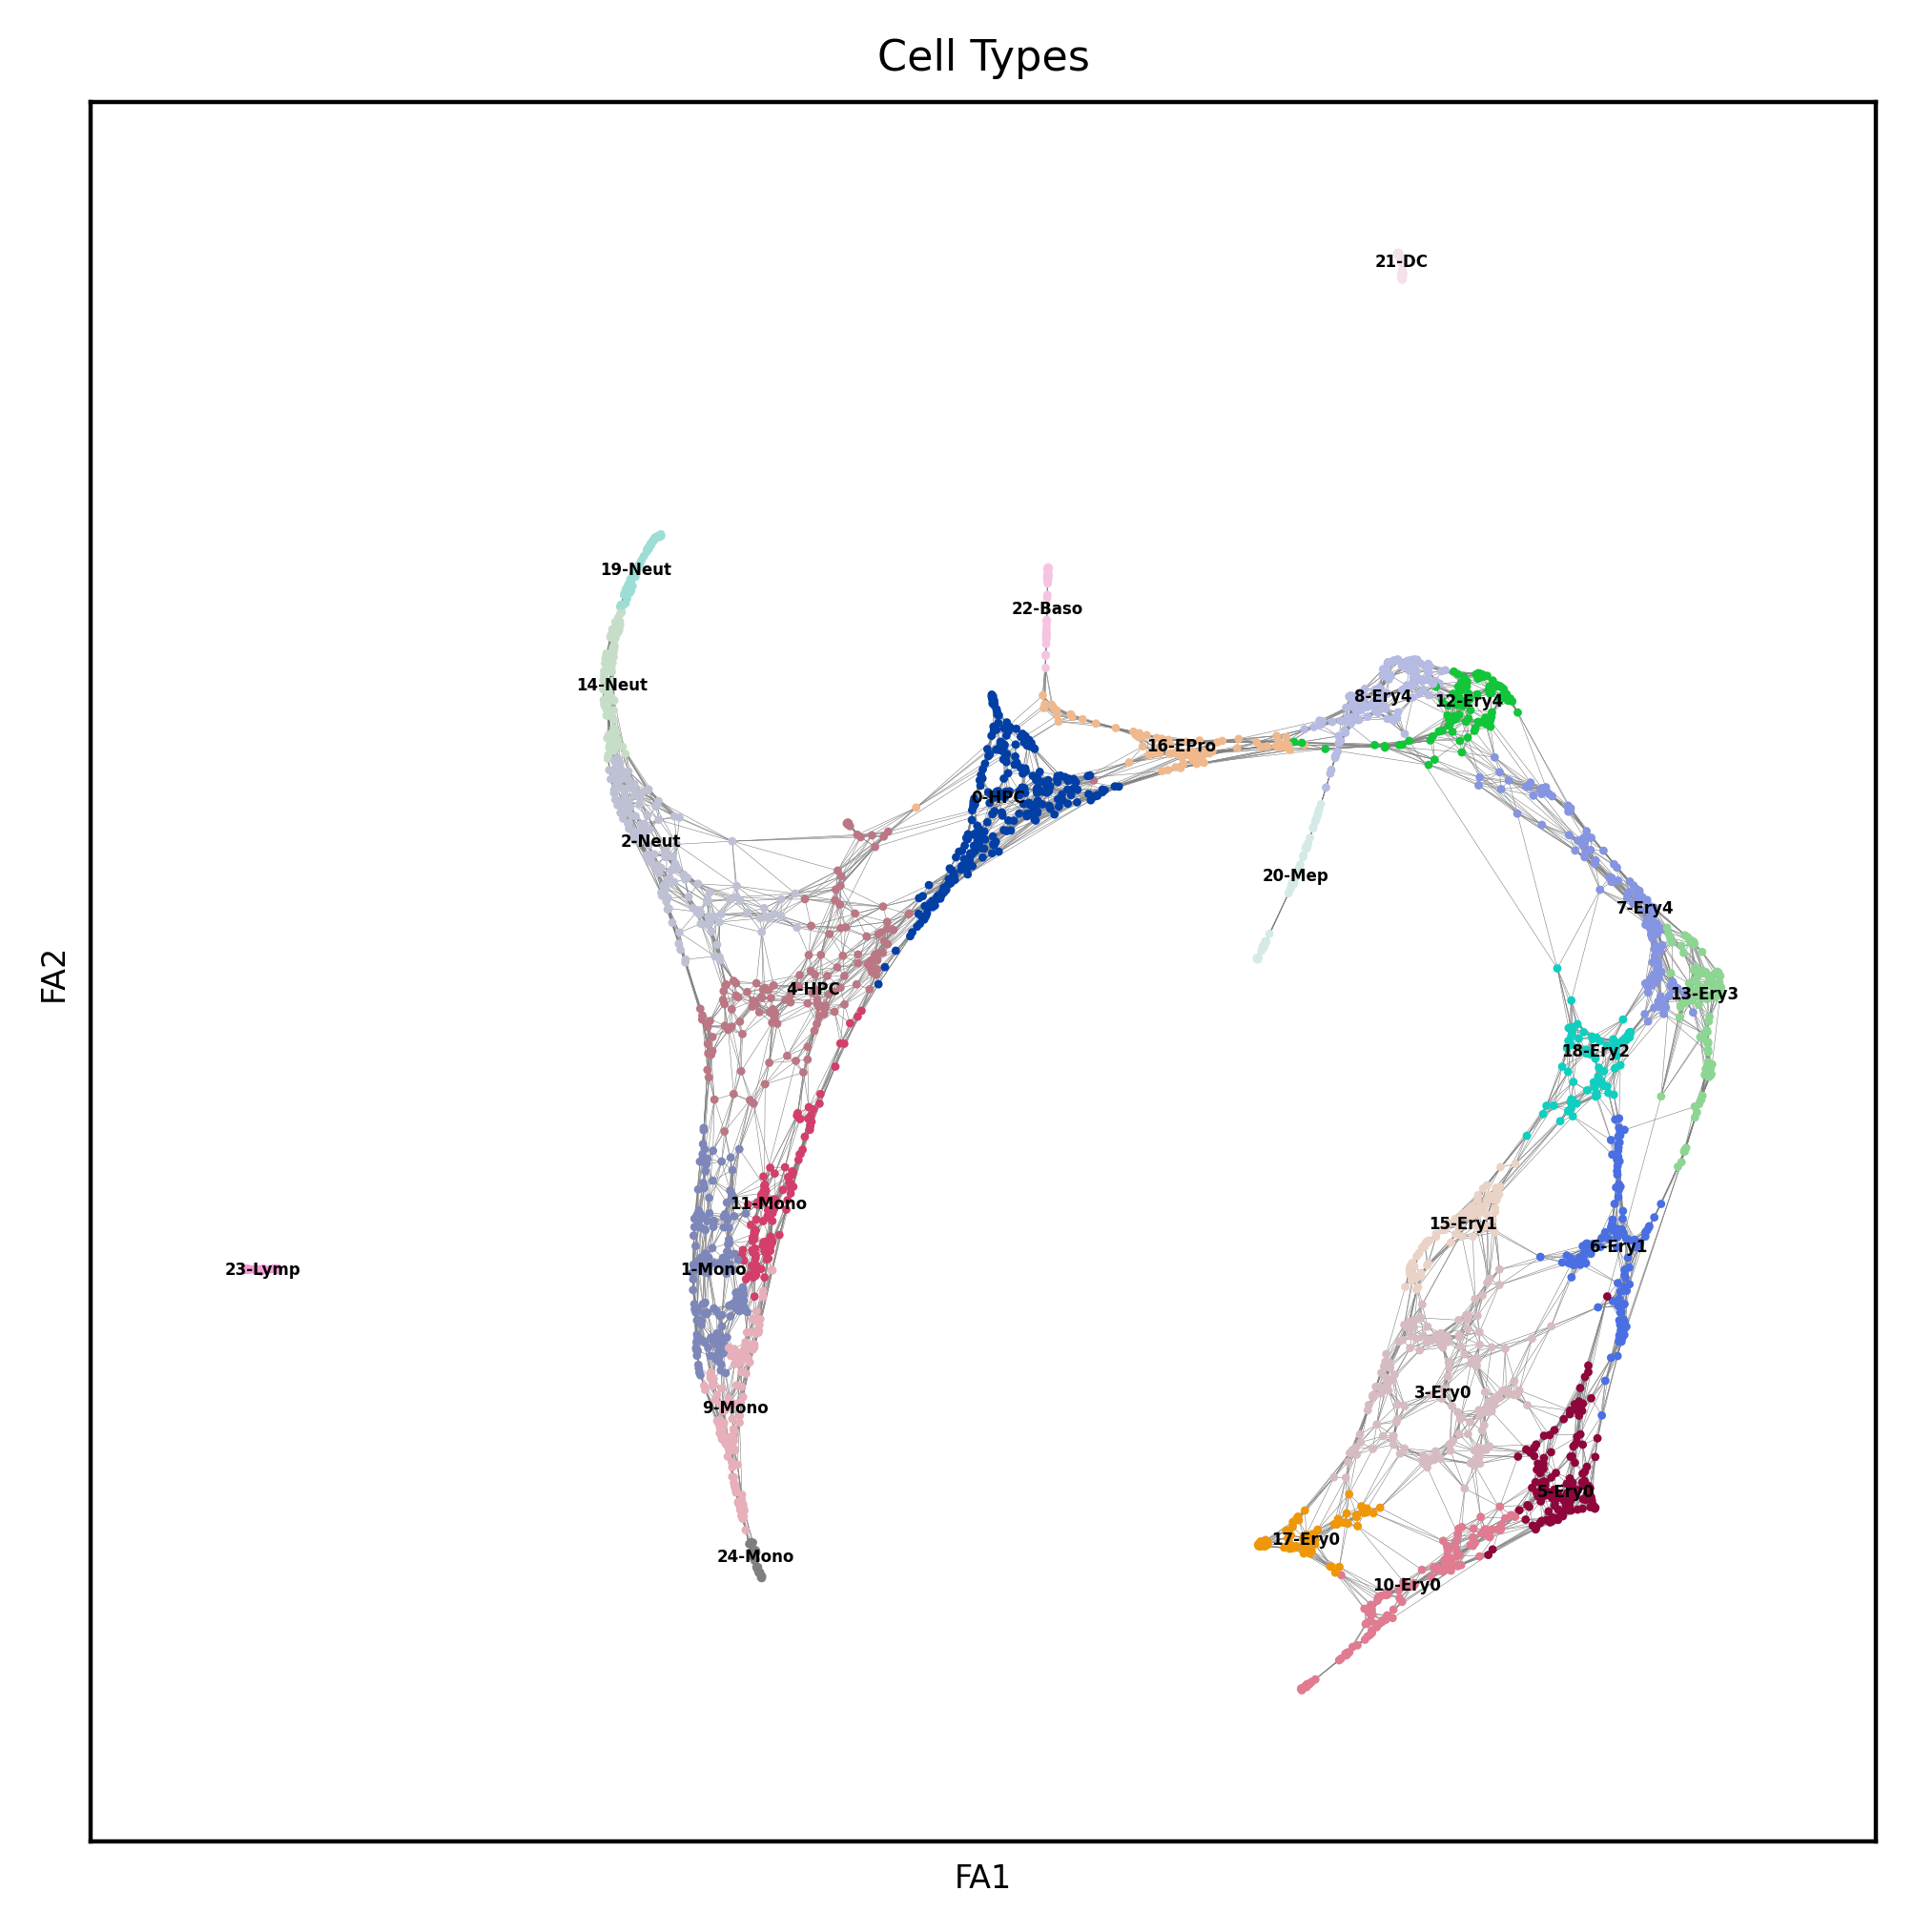

In [26]:
# Set the figure size and font sizes for tick labels, axis labels, and titles
with rc_context({
    "figure.figsize": (6, 6),
    "xtick.labelsize": 4,
    "ytick.labelsize": 4,
    "axes.labelsize": 6,  # Font size for axis labels
    "axes.titlesize": 8   # Font size for titles
}):
    sc.pl.draw_graph(
        adata, color=["cell_type_new_names"],
        legend_loc="on data",
        title="Cell Types",
        size=10,
        legend_fontsize=3,
        frameon=True,
        save=True,
        edges=True
    )

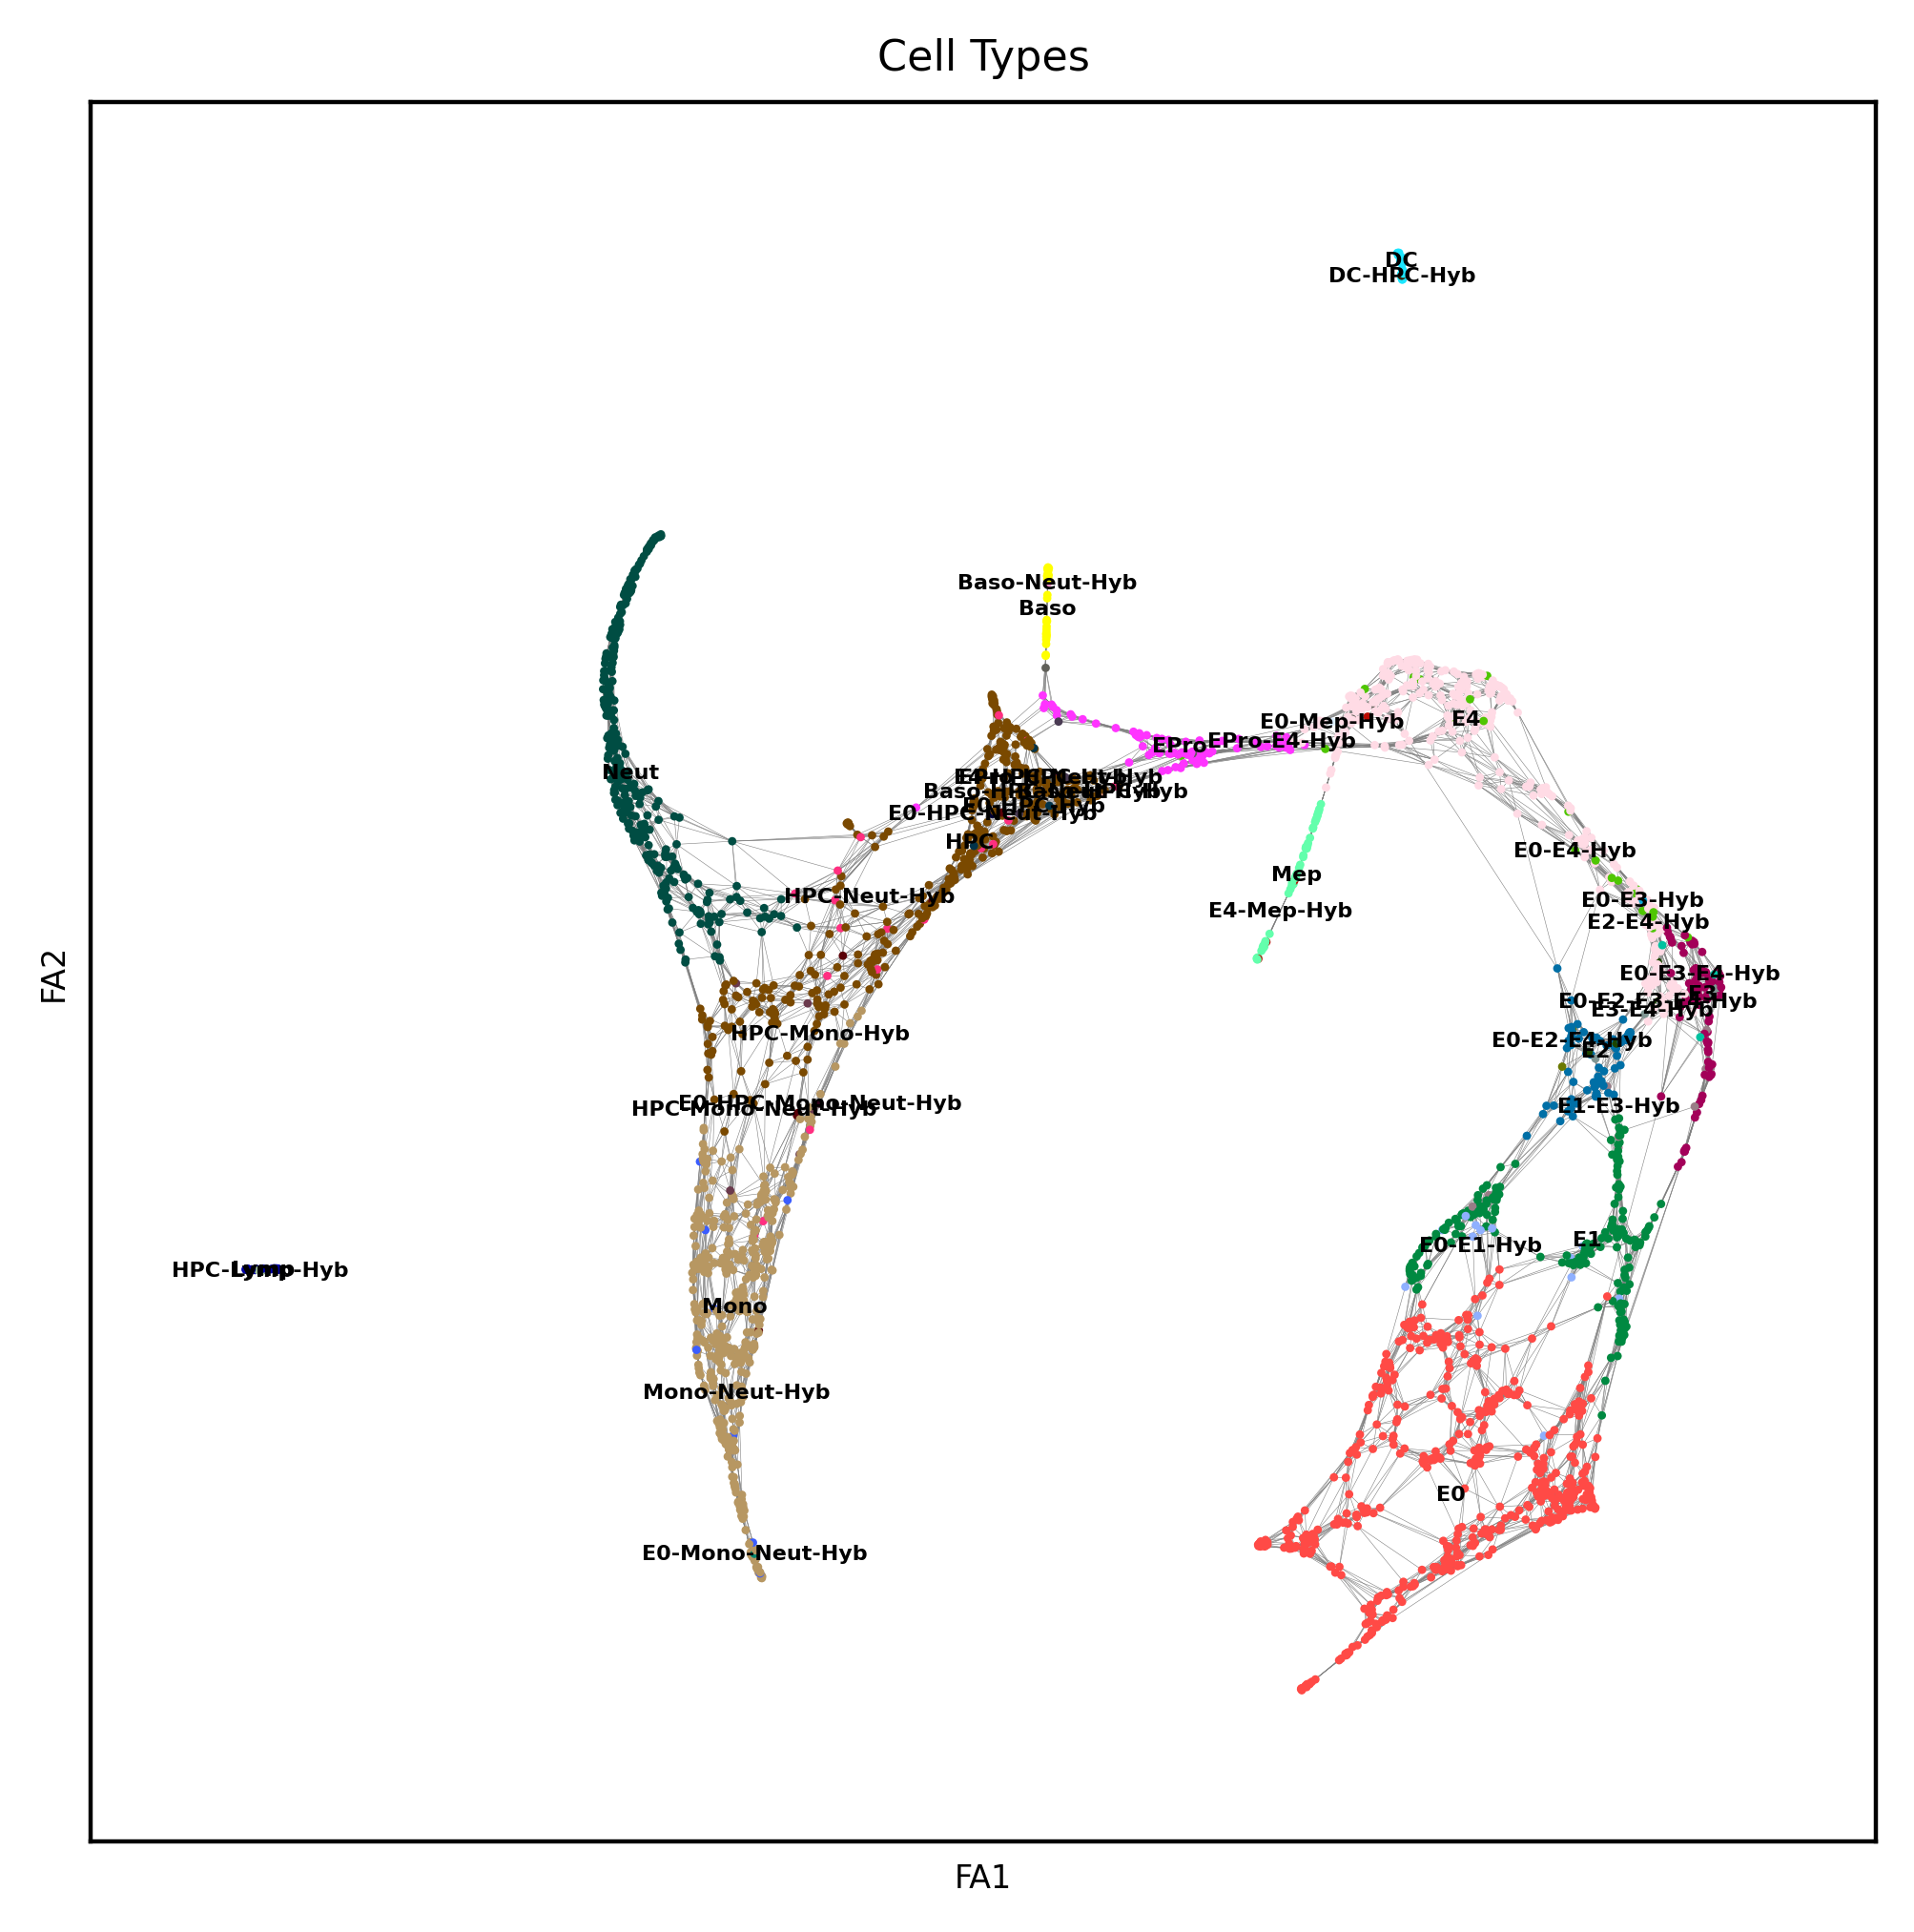

In [25]:
# Set the figure size and font sizes for tick labels, axis labels, and titles
with rc_context({
    "figure.figsize": (6, 6),
    "xtick.labelsize": 4,
    "ytick.labelsize": 4,
    "axes.labelsize": 6,  # Font size for axis labels
    "axes.titlesize": 8   # Font size for titles
}):
    sc.pl.draw_graph(
        adata, color=["cell_type_hyb"],
        legend_loc="on data",
        title="Cell Types",
        size=10,
        legend_fontsize=4,
        frameon=True,
        edges=True,
        save=True
    )